In [1]:
%%time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf

CPU times: total: 4.59 s
Wall time: 6.56 s


In [2]:
df = pd.read_csv("Restaurant reviews.csv")
df.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


In [3]:
df = df.drop(["Restaurant", "Reviewer", "Metadata", "Time", "Pictures", "7514"], axis=1)
df.head()

,Review,Rating
0,"The ambience was good, food was quite good . h...",5
1,Ambience is too good for a pleasant evening. S...,5
2,A must try.. great food great ambience. Thnx f...,5
3,Soumen das and Arun was a great guy. Only beca...,5
4,Food is good.we ordered Kodi drumsticks and ba...,5


In [4]:
df["Rating"].unique()

array(['5', '4', '1', '3', '2', '3.5', '4.5', '2.5', '1.5', 'Like', nan],
      dtype=object)

In [5]:
df["Rating"] = df["Rating"][df["Rating"] != "Like"].astype(float)
df["Sentiment"] = df["Rating"].apply(lambda x: 1 if x >= 3 else 0)

In [6]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9954 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Review     9954 non-null   object 
 1   Rating     9954 non-null   float64
 2   Sentiment  9954 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 311.1+ KB


# Tokenizer

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=8_000, oov_token="<OOV>")

tokenizer.fit_on_texts(df["Review"])

# Truncating The Data

In [8]:
previous_shape = df.shape

In [9]:
lengths = list(map(lambda x: len(x.split(" ")), df["Review"]))

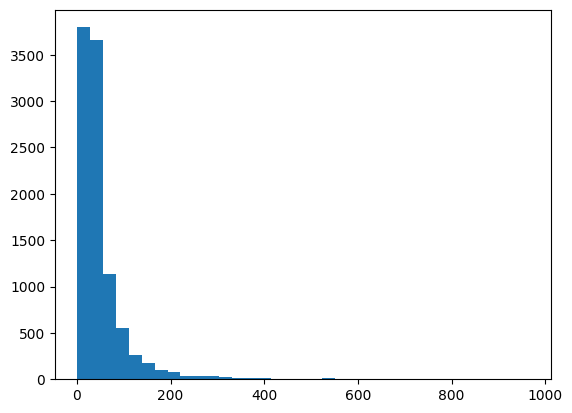

In [10]:
plt.hist( lengths, bins=len(set(lengths))//10 )
plt.show()

In [11]:
max_len = 100

In [12]:
df = df[df['Review'].apply(lambda x: len(x.split(" ")) <= max_len)].reset_index(drop=True)

In [13]:
lengths = list(map(lambda x: len(x.split(" ")), df["Review"]))

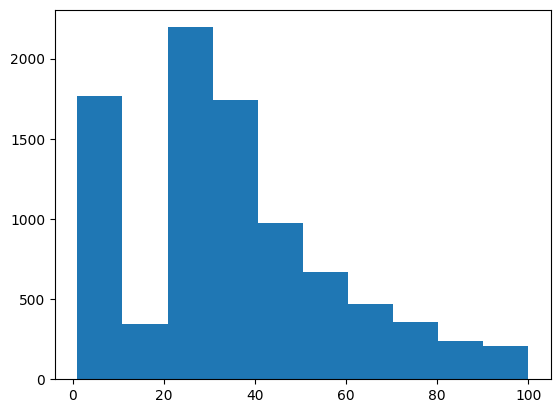

In [14]:
plt.hist( lengths, bins=len(set(lengths))//10 )
plt.show()

In [15]:
# About 1000 were dropped
df.shape, previous_shape

((8966, 3), (9954, 3))

# Padding The Data

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequence(tokenizer, data):
    sequences = tokenizer.texts_to_sequences(data)
    
    padded = pad_sequences(sequences,
                          padding="post",
                          maxlen=max_len)
    return padded

In [17]:
sequences = get_sequence(tokenizer, df["Review"])

# Splitting The Data

In [18]:
from sklearn.model_selection import train_test_split

X = sequences
y = df["Sentiment"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(7172, 100) (7172,)
(1794, 100) (1794,)


# Creating The Model

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(8_000, 64, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.1)),
    tf.keras.layers.Dense(2, activation="softmax")
])

In [21]:
model.compile(
    optimizer="adam",
    loss=     "sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           512000    
                                                                 
 bidirectional (Bidirection  (None, 100, 64)           24832     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 561794 (2.14 MB)
Trainable params: 561794 (2.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Running The model

In [23]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)
    ]
)

Epoch 1/10
225/225 [==============================] - 50s 165ms/step - loss: 0.3612 - accuracy: 0.8429 - val_loss: 0.2337 - val_accuracy: 0.9047
Epoch 2/10
225/225 [==============================] - 34s 151ms/step - loss: 0.1564 - accuracy: 0.9424 - val_loss: 0.1924 - val_accuracy: 0.9370
Epoch 3/10
225/225 [==============================] - 34s 149ms/step - loss: 0.1004 - accuracy: 0.9628 - val_loss: 0.2131 - val_accuracy: 0.9281
Epoch 4/10
225/225 [==============================] - 34s 152ms/step - loss: 0.0802 - accuracy: 0.9727 - val_loss: 0.2510 - val_accuracy: 0.9264
Epoch 5/10
225/225 [==============================] - 36s 158ms/step - loss: 0.0563 - accuracy: 0.9810 - val_loss: 0.3113 - val_accuracy: 0.9192


In [24]:
def plot_training_history(history):
    # Extract training history
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Plot training and validation loss
    axes[0].plot(loss, label='Training Loss')
    axes[0].plot(val_loss, label='Validation Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plot training and validation accuracy
    axes[1].plot(accuracy, label='Training Accuracy')
    axes[1].plot(val_accuracy, label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

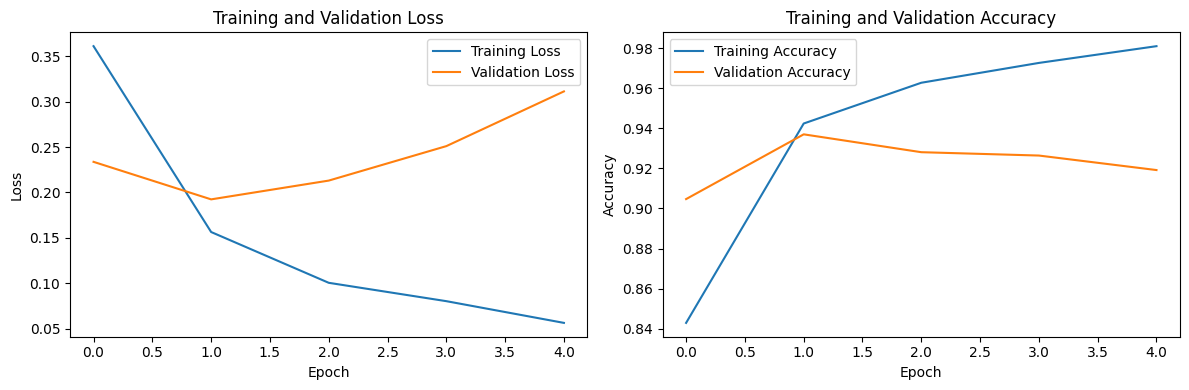

In [25]:
plot_training_history(history)

# Show Performance

In [26]:
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(true_labels, preds, classes):
    # Create the confusion matrix
    cm = confusion_matrix(true_labels, preds, normalize="true")
    
    plt.figure(figsize=(8, 8))

    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)

    plt.xticks( range(0, len(classes)), labels=classes )
    plt.yticks( range(0, len(classes)), labels=classes )

    plt.colorbar(ctx)
    plt.show()

In [27]:
preds = model.predict( x_test )

57/57 [==============================] - 5s 40ms/step


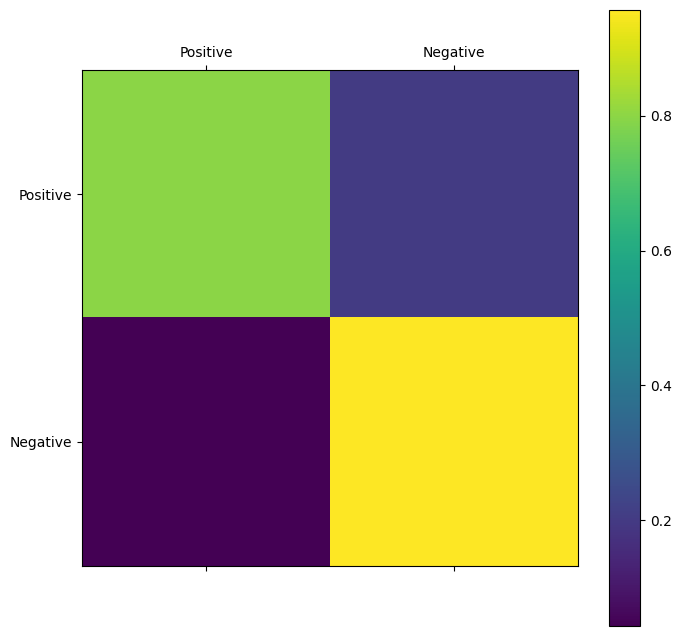

In [28]:
show_confusion_matrix(y_test, preds.argmax(axis=-1), ["Positive", "Negative"])